In [ ]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [134]:
def load_data(path, split_data=1):
    data = []
    labels = []
    listpath = os.listdir(path)
    total = len(listpath)
    for subpath in listpath:
        complete_subpath = os.path.join(path, subpath)
        images = os.listdir(complete_subpath)
        total_images = len(images)
        labels.extend([int(subpath) for _ in range(int(total_images*split_data))])
        for idx, image_name in enumerate(images[:int(total_images*split_data)]):
            image_path = os.path.join(complete_subpath, image_name)
            image = cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2GRAY).reshape(-1)
            data.append(image)
            print(f'Images: [{idx+1}/{int(total_images*split_data)}]> in label [{subpath}/{total-1}]', end='\r')
    return np.array(data), np.array(labels)

In [135]:
def one_hot(data, num_classes):
    new_data = np.zeros((data.shape[0], num_classes))
    new_data[np.arange(data.shape[0]), data] = 1
    return new_data

In [ ]:
path = r'\Deep Learning\datasets\fashion_mnist_images'
path_train = path + r'\train'
path_test = path + r'\test'

In [138]:
X_train, y_train = load_data(path_train)
X_test, y_test = load_data(path_test)

In [139]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

In [140]:
def im2col_strided(x, field_height, field_width, padding=0, stride=1):
    m, H, W, C = x.shape
    out_h = (H + 2 * padding - field_height) // stride + 1
    out_w = (W + 2 * padding - field_width) // stride + 1
    if padding > 0:
        x_padded = np.pad(x, ((0, 0), (padding, padding), (padding, padding), (0, 0)), mode='constant')
    else:
        x_padded = x
    shape = (m, out_h, out_w, field_height, field_width, C)
    strides = (x_padded.strides[0],
               stride * x_padded.strides[1],
               stride * x_padded.strides[2],
               x_padded.strides[1],
               x_padded.strides[2],
               x_padded.strides[3])
    return np.lib.stride_tricks.as_strided(x_padded, shape=shape, strides=strides), out_h, out_w

In [141]:
def fast_maxpool(x, pool_height, pool_width, stride=1, padding=0):
    x_strided, out_h, out_w = im2col_strided(x, pool_height, pool_width, padding, stride)
    out = np.max(x_strided, axis=(3, 4))
    return out, x_strided

In [142]:
def fast_maxpool_backprop(x, pool_height, pool_width, stride, padding, dout, x_strided):
    m, out_h, out_w, ph, pw, C = x_strided.shape

    max_val = np.max(x_strided, axis=(3, 4), keepdims=True)
    mask = (x_strided == max_val)
    mask = mask / np.sum(mask, axis=(3, 4), keepdims=True)
    dout_expanded = dout[:, :, :, None, None, :]

    dpatch = mask * dout_expanded
    m, H, W, C = x.shape
    H_padded = H + 2 * padding
    W_padded = W + 2 * padding

    dx_padded = np.zeros((m, H_padded, W_padded, C), dtype=x.dtype)

    for i in range(pool_height):
        for j in range(pool_width):
            dx_padded[:, i: i + stride * out_h: stride, j: j + stride * out_w: stride, :] += dpatch[:, :, :, i, j, :]
    
    if padding > 0:
        dx = dx_padded[:, padding:-padding, padding:-padding, :]
    else:
        dx = dx_padded
    return dx

In [143]:
def fast_convolution(x, W, b, padding=1, stride=1):
    m, H, W_in, C = x.shape
    fh, fw, _, K = W.shape
    x_strided, out_h, out_w = im2col_strided(x, fh, fw, padding, stride)

    out = np.einsum('mxyhwc,hwck->mxyk', x_strided, W, optimize='optimal')
    out += b
    return out.reshape(m, out_h, out_w, K)

In [144]:
def fast_convolution_backprop(x, W, dout, padding=1, stride=1):

    m, H, W_in, C = x.shape
    fh, fw, _, K = W.shape
    x_strided, out_h, out_w = im2col_strided(x, fh, fw, padding, stride)
    dout_reshaped = dout.reshape(m, out_h, out_w, K)
    
    dW = np.einsum('mxyhwc,mxyk->hwck', x_strided, dout_reshaped, optimize='optimal')
    
    db = np.sum(dout_reshaped, axis=(0, 1, 2), keepdims=True)
    
    dx_strided = np.einsum('mxyk,hwck->mxyhwc', dout_reshaped, W, optimize='optimal')
    dx_padded = np.zeros((m, H + 2*padding, W_in + 2*padding, C), dtype=x.dtype)
    
    for h in range(fh):
        for w in range(fw):
            dx_padded[:, 
                      h: h + stride*out_h: stride,
                      w: w + stride*out_w: stride,
                      :] += dx_strided[:, :, :, h, w, :]

    return (dx_padded[:, padding:-padding, padding:-padding, :] if padding > 0 else dx_padded), dW, db


In [145]:
def ReLU(x, derv=False):
    if derv: return np.where(x>0, 1, 0)
    return np.maximum(x, 0)

In [146]:
def LeakyReLU(x, alpha=0.2, derv=False):
    if derv: return np.where(x>0, 1, alpha)
    return np.where(x>0, x, x*alpha)

In [147]:
def softmax(x, derv=False):
    x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    s = x_exp / x_exp.sum(axis=1, keepdims=True)
    if derv: return s * (1 - s)
    return s

In [148]:
def CCE(y, y_pred, epsilon=1e-8, derv=False):
    if derv: return y_pred-y # In this case
    return -np.mean(y*np.log(y_pred+epsilon))

In [149]:
def accuracy(y, y_pred):
    return np.mean(np.argmax(y, axis=1)==np.argmax(y_pred, axis=1))

In [150]:
# Conv Layer 1
IN_CHANNELS_0 = 1
OUT_CHANNELS_0 = 4
KERNEL_0 = (3, 3)
STRIDE_0 = 1
PADDING_0 = 1

conv_W0 = np.random.randn(KERNEL_0[0], KERNEL_0[1], IN_CHANNELS_0, OUT_CHANNELS_0) * 0.1
conv_b0 = np.zeros((1, 1, 1, OUT_CHANNELS_0))

conv_out_0 = (X_train.shape[1], X_train.shape[2], OUT_CHANNELS_0)

In [151]:
# Max-pool Layer 1
POOL_SIZE_1_1 = 2
POOL_SIZE_2_1 = 2
STRIDE_1 = 2
PADDING_1 = 0

pool_out_1 = (X_train.shape[1]//2, X_train.shape[2]//2, OUT_CHANNELS_0)

In [152]:
# Conv Layer 2
IN_CHANNELS_2 = 4
OUT_CHANNELS_2 = 4
KERNEL_2 = (3, 3)
STRIDE_2 = 1
PADDING_2 = 1

conv_W2 = np.random.randn(KERNEL_2[0], KERNEL_2[1], IN_CHANNELS_2, OUT_CHANNELS_2) * 0.1
conv_b2 = np.zeros((1, 1, 1, OUT_CHANNELS_2))

conv_out_2 = (X_train.shape[1]//2, X_train.shape[2]//2, OUT_CHANNELS_2)

In [153]:
# Max-pool Layer 2

POOL_SIZE_1_3 = 2
POOL_SIZE_2_3 = 2
STRIDE_3 = 2
PADDING_3 = 0

# (m, H/4, W/4, OUT_CHANNELS_2)

pool_out_3 = (X_train.shape[1]//4, X_train.shape[2]//4, OUT_CHANNELS_2)

In [154]:
flat_dim = np.prod(pool_out_3)

W0 = np.random.randn(flat_dim, 128) * np.sqrt(2/flat_dim)
b0 = np.zeros((1, 128))

W1 = np.random.randn(128, 64) * np.sqrt(2/128)
b1 = np.zeros((1, 64))

W2 = np.random.randn(64, y_train.shape[1]) * np.sqrt(2/64)
b2 = np.zeros((1, y_train.shape[1]))

params = [conv_W0, conv_b0, conv_W2, conv_b2, W0, b0, W1, b1, W2, b2]
len_params = len(params)

In [155]:
# Adam settings
lr = 0.005
current_lr = lr
decay = 0
t = 1
m = [0] * len_params
v = [0] * len_params
beta_1 = 0.9
beta_2 = 0.999
epsilon_adam = 1e-8

In [156]:
def optimizer_adam(grads, i):
    m[i] = beta_1 * m[i] + (1 - beta_1) * grads
    v[i] = beta_2 * v[i] + (1 - beta_2) * grads**2
    m_h = m[i] / (1 - beta_1**t)
    v_h = v[i] / (1 - beta_2**t)
    return m_h / (np.sqrt(v_h) + epsilon_adam)

In [157]:
def prev_step():
    global current_lr
    if decay:
        current_lr = lr * (1 / (1 + decay * t))

In [158]:
def step():
    global t
    t += 1

In [159]:
def update_params(grads):
    prev_step()
    for i in range(len_params):
        params[i][...] = params[i] - current_lr * optimizer_adam(grads[i], i)
    step()

In [ ]:
def forward(x):
    global conv_z0, conv_a0, pool_conv_a0, pool_x_strided_0
    global conv_z1, conv_a1, pool_conv_a1, pool_x_strided_1
    global flat, z0, a0, z1, a1, z2, a2

    conv_z0 = fast_convolution(x, conv_W0, conv_b0, padding=PADDING_0, stride=STRIDE_0)
    conv_a0 = LeakyReLU(conv_z0)
    pool_conv_a0, pool_x_strided_0 = fast_maxpool(
        conv_a0, POOL_SIZE_1_1, POOL_SIZE_2_1, 
        stride=STRIDE_1, padding=PADDING_1
    )

    conv_z1 = fast_convolution(pool_conv_a0, conv_W2, conv_b2, padding=PADDING_2, stride=STRIDE_2)
    conv_a1 = LeakyReLU(conv_z1)
    pool_conv_a1, pool_x_strided_1 = fast_maxpool(
        conv_a1, POOL_SIZE_1_3, POOL_SIZE_2_3,
        stride=STRIDE_3, padding=PADDING_3
    )

    flat = pool_conv_a1.reshape(pool_conv_a1.shape[0], -1)

    z0 = flat @ W0 + b0
    a0 = LeakyReLU(z0)

    z1 = a0 @ W1 + b1
    a1 = LeakyReLU(z1)

    z2 = a1 @ W2 + b2
    a2 = softmax(z2)

    return a2


In [161]:
def backward(x=None, y=None, outp=None, deltas=None, learn=True):
    if y is not None:
        dL = CCE(y, outp, derv=True)
    elif deltas is not None:
        dL = deltas
    else: raise ValueError('there is no (y) or (deltas)')
    m = dL.shape[0]

    dW2 = a1.T @ dL / m
    db2 = dL.sum(axis=0, keepdims=True) / m

    da1 = dL @ W2.T
    dz1 = da1 * LeakyReLU(z1, derv=True)

    dW1 = a0.T @ dz1 / m
    db1 = dz1.sum(axis=0, keepdims=True) / m

    da0 = dz1 @ W1.T
    dz0 = da0 * LeakyReLU(z0, derv=True)

    dW0 = flat.T @ dz0 / m
    db0 = dz0.sum(axis=0, keepdims=True) / m

    dflat = dz0 @ W0.T

    dpool_conv_a1 = dflat.reshape(pool_conv_a1.shape)

    d_conv_a1 = fast_maxpool_backprop(conv_a1, POOL_SIZE_1_3, POOL_SIZE_2_3, STRIDE_3, PADDING_3, dpool_conv_a1, pool_x_strided_1)

    d_conv_z1 = d_conv_a1 * LeakyReLU(conv_z1, derv=True)

    dx_conv1, dW2_conv, db2_conv = fast_convolution_backprop(pool_conv_a0, conv_W2, d_conv_z1, padding=PADDING_2, stride=STRIDE_2)

    d_conv_a0 = fast_maxpool_backprop(conv_a0, POOL_SIZE_1_1, POOL_SIZE_2_1, STRIDE_1, PADDING_1, dx_conv1, pool_x_strided_0)

    d_conv_z0 = d_conv_a0 * LeakyReLU(conv_z0, derv=True)

    dx_input, dW0_conv, db0_conv = fast_convolution_backprop(x, conv_W0, d_conv_z0, padding=PADDING_0, stride=STRIDE_0)

    grads = dW0_conv, db0_conv, dW2_conv, db2_conv, dW0, db0, dW1, db1, dW2, db2

    if learn:
        update_params(grads)

    return dx_input, grads

In [162]:
def train(x, y, epochs=50, batch_size=128, print_every=0.1):
    losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
        
        epoch_loss = 0.0
        epoch_acc = 0.0
        num_batches = 0
        
        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            preds = forward(x_batch)
            loss = CCE(y_batch, preds)
            acc = accuracy(y_batch, preds)
            epoch_loss += loss
            epoch_acc += acc
            num_batches += 1
            
            backward(x_batch, y_batch, outp=preds, learn=True)
            print(f"Epoch {epoch}, Batch {i//batch_size + 1}", end='\r')
        
        avg_loss = epoch_loss / num_batches
        avg_acc = epoch_acc / num_batches
        losses.append(avg_loss)
        accuracies.append(avg_acc)
        if epoch % max(1, int(epochs * print_every)) == 0:
            print(f'Epoch: [{epoch}/{epochs}]> Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}')
    return losses, accuracies

In [163]:
history_loss, history_acc = train(
    x=X_train,
    y=y_train,
    epochs=10,
    batch_size=128,
    print_every=0.1
)

Epoch: [1/10]> Loss: 0.0518, Acc: 0.8079
Epoch: [2/10]> Loss: 0.0352, Acc: 0.8713
Epoch: [3/10]> Loss: 0.0318, Acc: 0.8821
Epoch: [4/10]> Loss: 0.0298, Acc: 0.8877
Epoch: [5/10]> Loss: 0.0285, Acc: 0.8927
Epoch: [6/10]> Loss: 0.0273, Acc: 0.8977
Epoch: [7/10]> Loss: 0.0262, Acc: 0.9007
Epoch: [8/10]> Loss: 0.0254, Acc: 0.9044
Epoch: [9/10]> Loss: 0.0246, Acc: 0.9073
Epoch: [10/10]> Loss: 0.0241, Acc: 0.9085


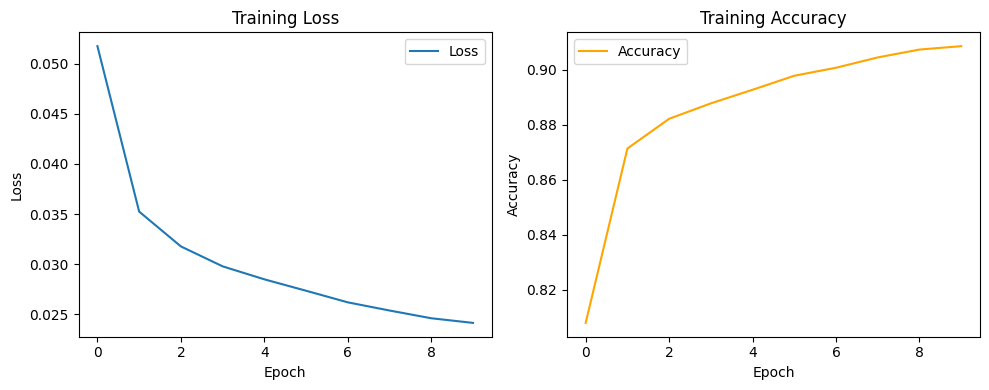

In [164]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_loss, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_acc, label='Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def visualize_feature_maps(image, layer_output, layer_name="", n_cols=4, base_size=3):
    if len(image.shape) == 4:
        image = image[0]

    feature_maps = layer_output[0]
    n_channels = feature_maps.shape[-1]
    n_rows = np.ceil(n_channels / n_cols).astype(int)

    fig_height = base_size * (n_rows + 1)
    fig_width = base_size * n_cols
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    gs = gridspec.GridSpec(n_rows + 1, n_cols, figure=fig)

    ax_img = fig.add_subplot(gs[0, :])
    ax_img.imshow(image.squeeze(), cmap='gray')
    ax_img.set_title('Input Image')
    ax_img.axis('off')

    fig.suptitle(f'Feature Maps: {layer_name}', fontsize=14)

    for i in range(n_channels):
        row = (i // n_cols) + 1
        col = i % n_cols

        ax = fig.add_subplot(gs[row, col])
        channel = feature_maps[:, :, i]
        if channel.max() > channel.min():
            channel = (channel - channel.min()) / (channel.max() - channel.min())

        ax.imshow(channel, cmap='viridis', vmin=0, vmax=1)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [179]:
idx = np.random.randint(0, X_test.shape[0])
sample_image = X_test[idx:idx+1]
_ = forward(sample_image)

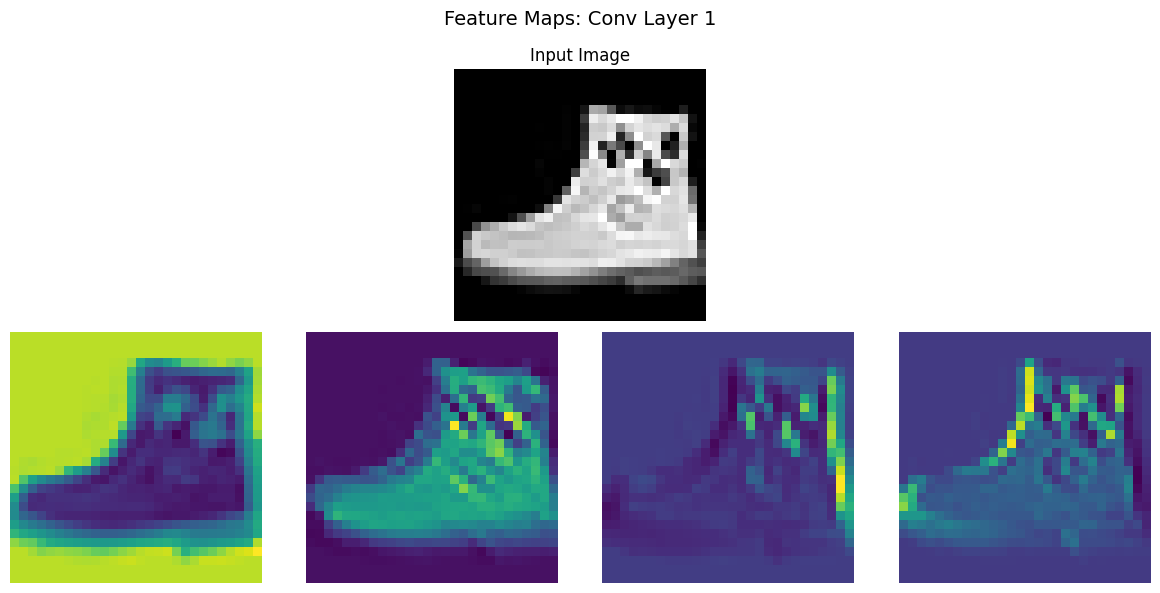

In [185]:
visualize_feature_maps(sample_image, conv_a0, "Conv Layer 1", 4)

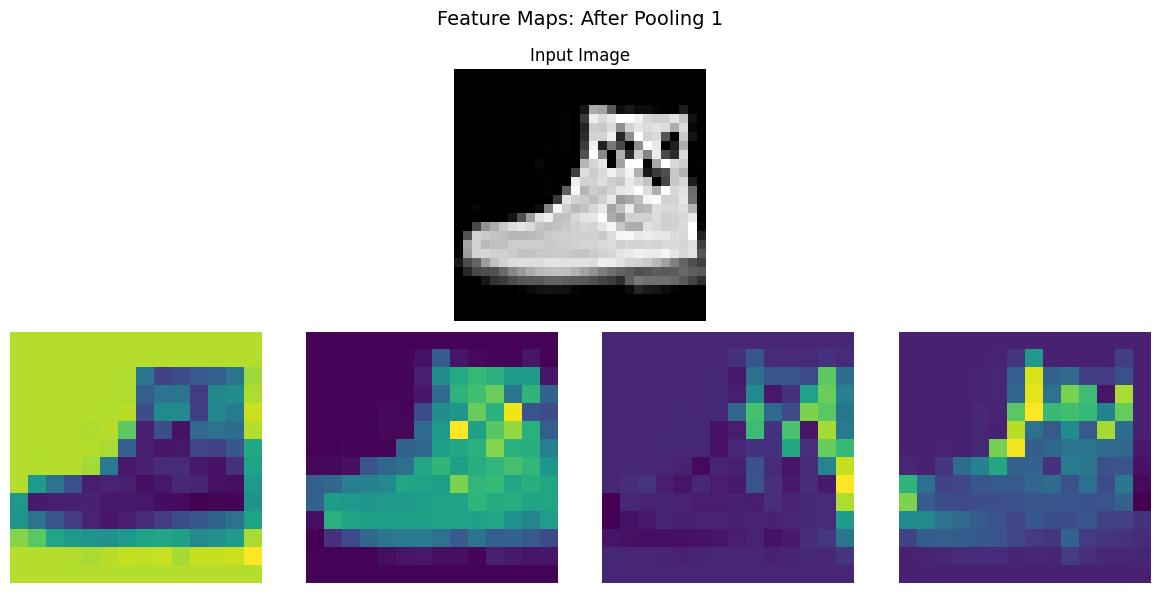

In [186]:
visualize_feature_maps(sample_image, pool_conv_a0, "After Pooling 1", 4)

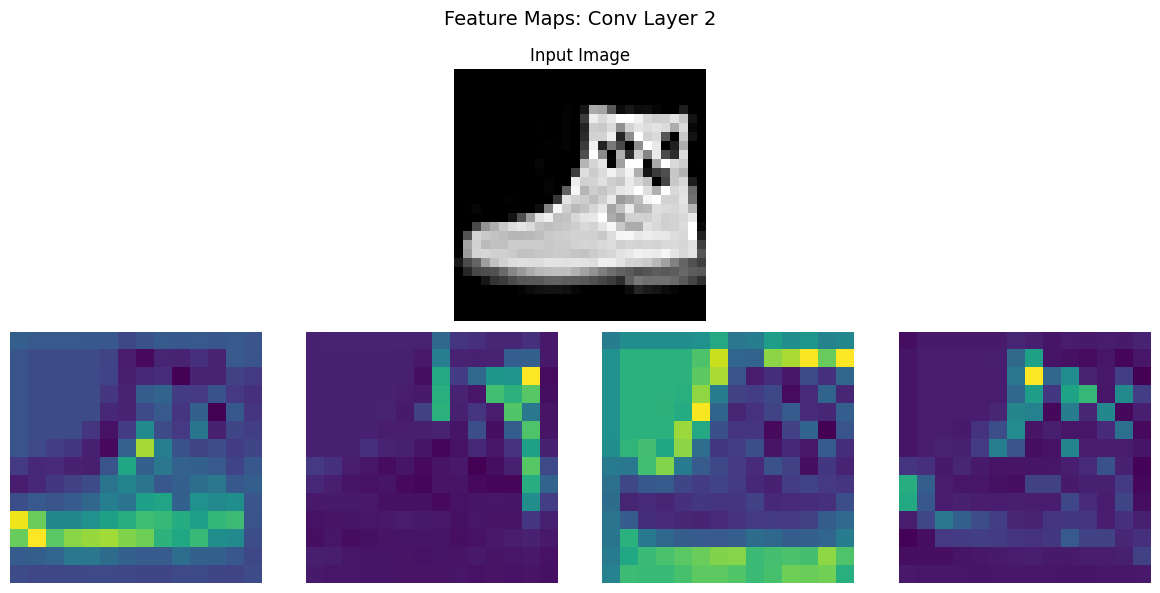

In [187]:
visualize_feature_maps(sample_image, conv_a1, "Conv Layer 2", 4)

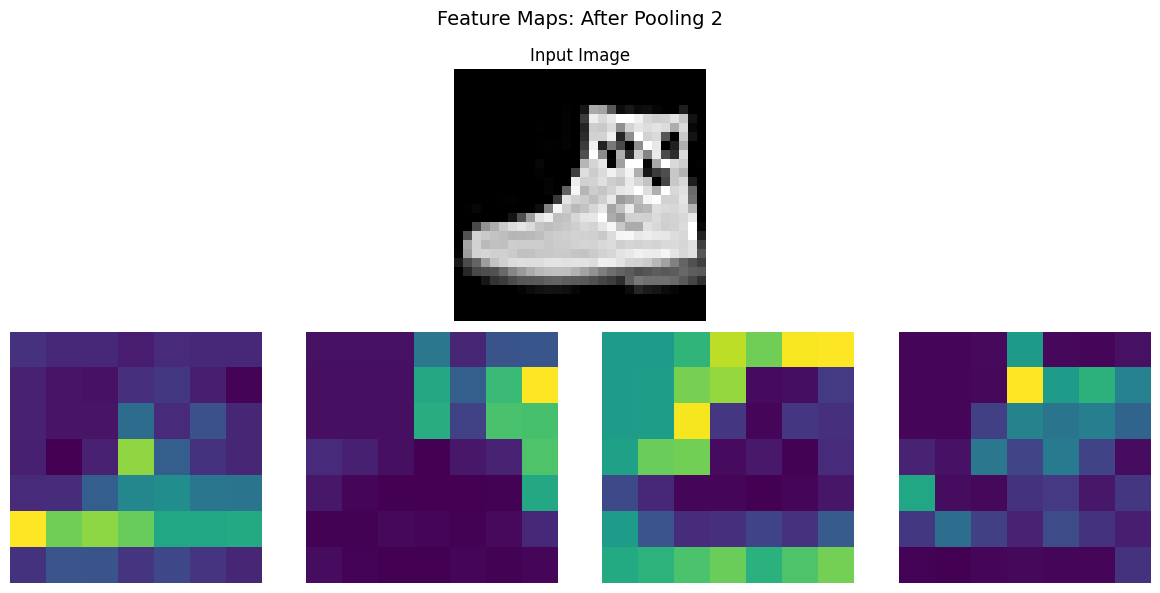

In [188]:
visualize_feature_maps(sample_image, pool_conv_a1, "After Pooling 2", 4)